<a href="https://colab.research.google.com/github/markpoxley/EELS-Autoencoders/blob/main/EELS_AutoencodersV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional autoencoders for data cleaning

*Prepared by Maxim Ziatdinov*

*Modified for EELS by Mark Oxley* 

Install extra-package(s) here:

In [ ]:
!pip install -q torchviz  # for vizualization (there are also some other more fancy visualization tools)

Imports:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchviz import make_dot

## Building blocks for Autoencoder

The most basic block of convolutional autoencoder is, obvioisly, a convolutional block. Let's define it here so that we can initialize/apply it later with just one line of code.

In [ ]:
class convblock(nn.Module):
    """
    Creates block of layers each consisting of convolution operation,
    leaky relu and (optionally) dropout and batch normalization

    Args:
        ndim: Data dimensionality (1D or 2D)
        nb_layers: Number of layers in the block
        input_channels: Number of input channels for the block
        output_channels: Number of the output channels for the block
        kernel_size: Size of convolutional filter (in pixels)
        stride: Stride of convolutional filter
        padding: Value for edge padding
        use_batchnorm: Add batch normalization to each layer in the block
        lrelu_a: negative slope coefficient in leaky ReLU activation
        dropout_: Dropout value for each layer in the block
    """
    def __init__(self, ndim: int , nb_layers: int, input_channels: int,
                 output_channels: int, kernel_size: int = 3,
                 stride: int = 1, padding: int = 1,
                 use_batchnorm: bool = True, lrelu_a: float = 0.01,
                 dropout_: float = 0) -> None:
        """
        Initializes module parameters
        """
        super(convblock, self).__init__()
        if not 0 < ndim < 3:
            raise AssertionError("ndim must be equal to 1 or 2")
        conv = nn.Conv2d if ndim == 2 else nn.Conv1d
        block = []
        for idx in range(nb_layers):
            input_channels = output_channels if idx > 0 else input_channels
            block.append(conv(input_channels,
                         output_channels,
                         kernel_size=kernel_size,
                         stride=stride,
                         padding=padding))
            if dropout_ > 0:
                block.append(nn.Dropout(dropout_))
            block.append(nn.LeakyReLU(negative_slope=lrelu_a))
            if use_batchnorm:
                if ndim == 2:
                    block.append(nn.BatchNorm2d(output_channels))
                else:
                    block.append(nn.BatchNorm1d(output_channels))
        self.block = nn.Sequential(*block)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Defines a forward pass
        """
        output = self.block(x)
        return output

Most of convolutional autoencoders downsample training images as they propagate through the encoder part of the network. Then, in the decoder part, we upsample them back to the original resolution. The downsampling is trivial, but let's write a separate class for upsampling (generally, however, it is better to avoid too much of downsampling/upsampling as this could lead to some image artefacts).

In [ ]:
class upsample_block(nn.Module):
    """
    Defines upsampling block performed using bilinear
    or nearest-neigbor interpolation followed by 1-by-1 convolution
    (the latter can be used to reduce a number of feature channels)

    Args:
        ndim: Data dimensionality (1D or 2D)
        input_channels: Number of input channels for the block
        output_channels: Number of the output channels for the block
        scale_factor: Scale factor for upsampling
        mode: Upsampling mode (select between "bilinear" and "nearest")
    """
    def __init__(self,
                 ndim: int,
                 input_channels: int,
                 output_channels: int,
                 scale_factor: int = 2,
                 mode: str = "bilinear") -> None:
        """
        Initializes module parameters
        """
        super(upsample_block, self).__init__()
        if not any([mode == 'bilinear', mode == 'nearest']):
            raise NotImplementedError(
                "use 'bilinear' or 'nearest' for upsampling mode")
        if not 0 < ndim < 3:
            raise AssertionError("ndim must be equal to 1 or 2")
        conv = nn.Conv2d if ndim == 2 else nn.Conv1d
        self.scale_factor = scale_factor
        self.mode = mode if ndim == 2 else "nearest"
        self.conv = conv(
            input_channels, output_channels,
            kernel_size=1, stride=1, padding=0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Defines a forward pass
        """
        x = F.interpolate(
            x, scale_factor=self.scale_factor, mode=self.mode)
        return self.conv(x)

## Define Autoencoder neural network

We now can write a simple (fully-) convolutional autoencoder:

In [ ]:
class cAE(nn.Module):
    """
    (fully) Convolutional autoencoder (without a fully-connected bottleneck layer)
    """
    def __init__(self):
        """
        Initialize cAE's parameters
        """
        super(cAE, self).__init__()
        self.encoder = nn.Sequential(
            convblock(1, 1, 1, 8),
            nn.MaxPool1d(2, 2),
            convblock(1, 2, 8, 16),
            nn.MaxPool1d(2, 2),
            convblock(1, 2, 16, 32),
            nn.MaxPool1d(2, 2)
        )
        self.decoder = nn.Sequential(
            convblock(1, 2, 32, 64),  # technically, this is a "bottleneck" layer, but we make it a part of decoder
            upsample_block(1, 64, 64),
            convblock(1, 2, 64, 32),
            upsample_block(1, 32, 32),
            convblock(1, 2, 32, 16),
            upsample_block(1, 16, 16),
            convblock(1, 1, 16, 8),
            nn.Conv1d(8, 1, 1) # vanilla 2D convolutional layer without activation
        )

    def forward(self, x: torch.Tensor):
        x = self.encoder(x)
        return self.decoder(x)

Let's visualize our model:

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


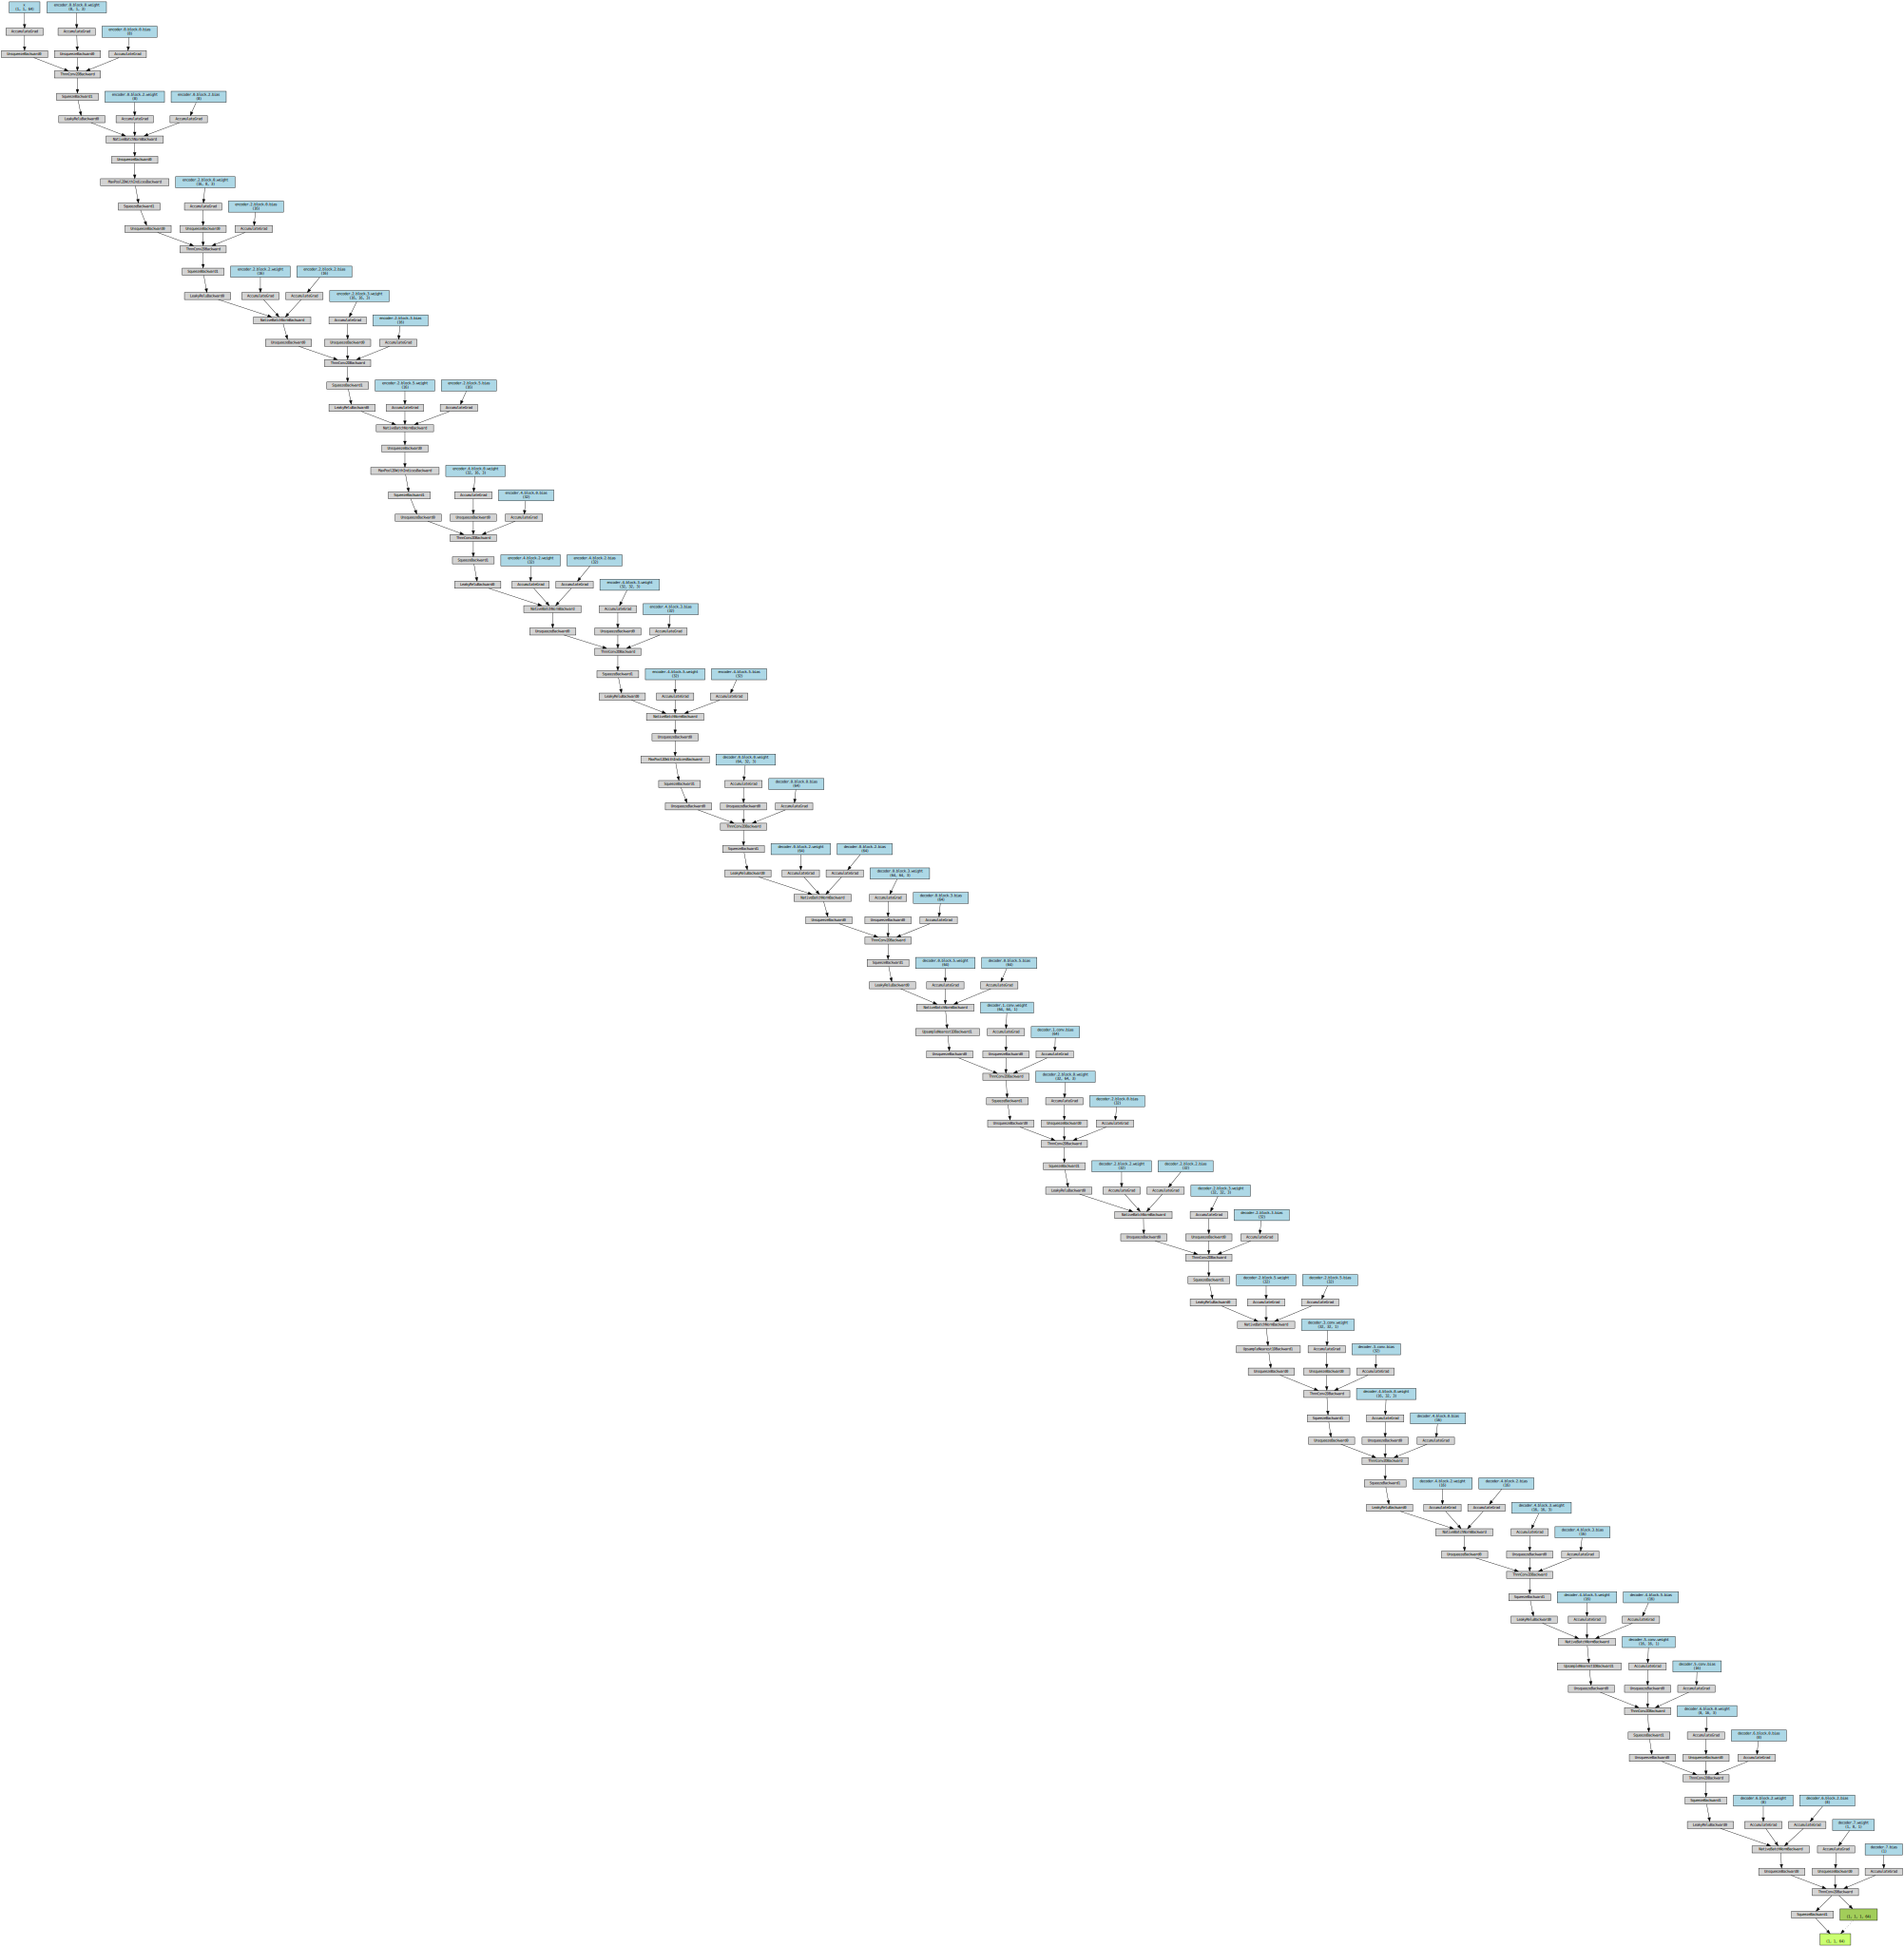

In [ ]:
model = cAE()
x = torch.randn( 1, 1, 64).requires_grad_(True)

y = model(x)
make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))

## Training/test data

Now that we have our model let's load some data to see if/how it works:

The next few cells contain links to example files

In [ ]:
# The simulated O K-shell data
!gdown https://drive.google.com/uc?id=1UeSxz9IcdP2s2AFTZeqXcSUhdu7eBlMA

Downloading...
From: https://drive.google.com/uc?id=1UeSxz9IcdP2s2AFTZeqXcSUhdu7eBlMA
To: /content/sim_crop.npy
100% 682k/682k [00:00<00:00, 45.0MB/s]


In [ ]:
# The simulated O K-shell data interpolated to match the experimental Fe L-shell data
!gdown https://drive.google.com/uc?id=1Qlj1j9SXHh6JfSiciXSTBYlAsjFpDX_3

Downloading...
From: https://drive.google.com/uc?id=1Qlj1j9SXHh6JfSiciXSTBYlAsjFpDX_3
To: /content/sim_norm_int.npy
100% 974k/974k [00:00<00:00, 62.6MB/s]


In [ ]:
# The simulated O K-shell data interpolated to match the experimental Fe L-shell data with additional factoring
!gdown https://drive.google.com/uc?id=1GmdCfxLd1L5Djk-wkduJfXo8rlBhr72B

Downloading...
From: https://drive.google.com/uc?id=1GmdCfxLd1L5Djk-wkduJfXo8rlBhr72B
To: /content/sim_norm_int_fac.npy
100% 974k/974k [00:00<00:00, 61.3MB/s]


In [ ]:
temp  = np.load('sim_norm_int_fac.npy')
temp.shape


(80, 39, 39)

Normalize to (0,1) so that stochastic gradient decent will behave nicely:

In [ ]:
norm = lambda x: (x - x.min()) / x.ptp()
imgdata = norm(temp)

See what the data looks like.

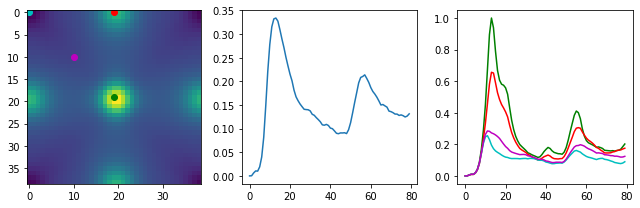

In [ ]:
SI = np.mean(imgdata, axis = 0)

fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=False)
axs[0].imshow(SI)
axs[1].plot(np.mean(imgdata,axis = (1,2)))
axs[0].plot(19, 19, 'o', color='g')
axs[2].plot(imgdata[:,19,19], color='g')
axs[0].plot(19, 0, 'o', color='r')
axs[2].plot(imgdata[:,19,0], color='r' )
axs[0].plot(0, 0, 'o', color='c')
axs[2].plot(imgdata[:,0,0], color='c')
axs[0].plot(10, 10, 'o', color='m')
axs[2].plot(imgdata[:,10,10], color='m')


fig.tight_layout()
plt.show()



In [ ]:
sigma = 0.046
imgdata_noisy = imgdata + np.random.normal(scale=sigma, size=imgdata.shape)


Look at the noisy data

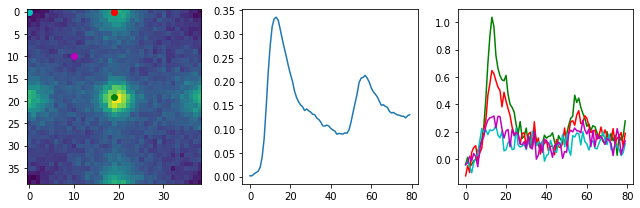

In [ ]:
SIn = np.mean(imgdata_noisy, axis = 0)

fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=False)
axs[0].imshow(SIn)
axs[1].plot(np.mean(imgdata_noisy,axis = (1,2)))
axs[0].plot(19, 19, 'o', color='g')
axs[2].plot(imgdata_noisy[:,19,19], color='g')
axs[0].plot(19, 0, 'o', color='r')
axs[2].plot(imgdata_noisy[:,19,0], color='r' )
axs[0].plot(0, 0, 'o', color='c')
axs[2].plot(imgdata_noisy[:,0,0], color='c')
axs[0].plot(10, 10, 'o', color='m')
axs[2].plot(imgdata_noisy[:,10,10], color='m')


fig.tight_layout()
plt.show()



Put data in correct format

data(nE, nopiy, nopix) to data(nopiy*nopix, nE)

In [ ]:
nE, nopiy,nopix = imgdata.shape
print(nE,nopiy,nopix)
temp = imgdata.reshape(nE,nopiy*nopix)
temp =temp.T
imgdata2 = temp
print(temp.shape)
temp = imgdata_noisy.reshape(nE,nopiy*nopix)
temp =temp.T
imgdata_noisy2 = temp


80 39 39
(1521, 80)


Split data into training and test sets:

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    imgdata_noisy2[:, np.newaxis], imgdata2[:, np.newaxis], # add a pseudo-channel dimension
    test_size=0.2, random_state=42, shuffle=True)

## Train Autoencoder

Initialize pytorch dataloaders:

In [ ]:
minibatch_size = 32
device_ = 'cuda' if torch.cuda.is_available() else 'cpu'

# Prepare data
if isinstance(X_train, np.ndarray):
    tor = lambda x: torch.from_numpy(x).float().to(device_)
    X_train, X_test = tor(X_train), tor(X_test)
    y_train, y_test = tor(y_train), tor(y_test)
    
# Initialize dataloader
data_train = torch.utils.data.TensorDataset(X_train, y_train)
data_test = torch.utils.data.TensorDataset(X_test, y_test)
train_iterator = torch.utils.data.DataLoader(
    data_train, batch_size=minibatch_size, shuffle=True)
test_iterator = torch.utils.data.DataLoader(data_test, batch_size=minibatch_size)

Finally, we train a model:

In [ ]:
# this is for reproducibility. Note, however, that there is an uncontrollable randomness
# when using bilinear upsampling (default one) and training model on GPU
def rng_seed(seed: int) -> None:
    torch.manual_seed(seed)
    if torch.cuda.is_available(): # for GPU
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True # this slows things down a bit but is good for reproducibility
        torch.backends.cudnn.benchmark = False

num_epochs = 750 # number of training epochs (we can/should train it longer to get more accurate results)
rng_seed(1) # for reproducibility

model = cAE()  # initialize model
if torch.cuda.is_available():
    torch.cuda.empty_cache()
model.to(device_)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # standard Adam weights optimizer
criterion = nn.MSELoss()  # simple mean-squared error loss function
train_losses = []
test_losses = []
for e in range(num_epochs):
    c, c_test = 0, 0
    losses, losses_test = 0, 0
    model.train()  # train step
    for feature, target in train_iterator:
        # forward pass
        y_predicted = model(feature)
        # compare to "ground truth" (compute loss)
        loss = criterion(y_predicted, target)
        # do backpropagation to compute gradients
        loss.backward()
        # optimize weights
        optimizer.step() 
        # clear gradients
        optimizer.zero_grad()
        # add loss for this step
        losses += loss.item()
        c += 1
    else:  # test step
        model.eval() # turn off batchnorm and/or dropout layers
        # compute prediction and loss with deactivated autograd engine
        with torch.no_grad():
            for feature, target in test_iterator:
                y_predicted = model(feature)
                loss = criterion(y_predicted, target)
                losses_test += loss.item()
                c_test += 1
    # save losses
    train_losses.append(losses / c)
    test_losses.append(losses_test / c_test)
    # print statistics
    print('Epoch: {}... Training loss: {}... Test loss: {}'.format(
        e+1, np.round(train_losses[-1], 5), np.round(test_losses[-1], 5)))

Epoch: 1... Training loss: 0.05126... Test loss: 0.01635
Epoch: 2... Training loss: 0.00691... Test loss: 0.00349
Epoch: 3... Training loss: 0.00186... Test loss: 0.001
Epoch: 4... Training loss: 0.0008... Test loss: 0.00075
Epoch: 5... Training loss: 0.00061... Test loss: 0.00054
Epoch: 6... Training loss: 0.00052... Test loss: 0.00048
Epoch: 7... Training loss: 0.00047... Test loss: 0.00045
Epoch: 8... Training loss: 0.00043... Test loss: 0.00039
Epoch: 9... Training loss: 0.0004... Test loss: 0.00035
Epoch: 10... Training loss: 0.0004... Test loss: 0.00034
Epoch: 11... Training loss: 0.00034... Test loss: 0.00031
Epoch: 12... Training loss: 0.00031... Test loss: 0.00029
Epoch: 13... Training loss: 0.0003... Test loss: 0.00028
Epoch: 14... Training loss: 0.00028... Test loss: 0.00026
Epoch: 15... Training loss: 0.00028... Test loss: 0.00025
Epoch: 16... Training loss: 0.00027... Test loss: 0.00025
Epoch: 17... Training loss: 0.00026... Test loss: 0.00031
Epoch: 18... Training loss: 0

Plot training/test losses *vs* epoch:

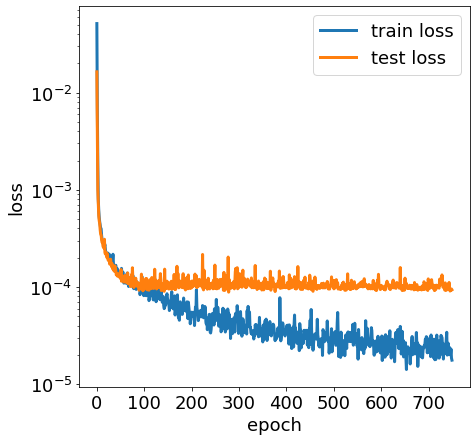

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(train_losses, linewidth=3)
plt.plot(test_losses, linewidth=3)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('loss', fontsize=18)
plt.xlabel('epoch', fontsize=18)
plt.legend(['train loss', 'test loss'], loc='upper right', fontsize=18)
plt.yscale("log")
plt.show()

Make a prediction on data:

The following cells provide links to simulated data with noise added and scaled experimental data

First the simulated data

In [ ]:
# Noisy simulated O K-shell data with sigma = 0.05
!gdown https://drive.google.com/uc?id=1xh5-IqMFpWdj8KVjK4YZomk51vFx6aPK
# Noisy simulated O K-shell data with sigma = 0.1
!gdown https://drive.google.com/uc?id=1U_l3WyDcP6X9D-EceOKTQCU1oi2P8Pji
# Noisy simulated O K-shell data with sigma = 0.15
!gdown https://drive.google.com/uc?id=1Ebl1x9x1Rmp73cPnO84Zcm8dfnr4RIgb
# Noisy simulated O K-shell data with sigma = 0.2
!gdown https://drive.google.com/uc?id=1Po_DQq67E3rvUt2OpGMDio4L8RY9NxwY

Downloading...
From: https://drive.google.com/uc?id=1xh5-IqMFpWdj8KVjK4YZomk51vFx6aPK
To: /content/Noisy input(0.05).npy
100% 682k/682k [00:00<00:00, 97.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1U_l3WyDcP6X9D-EceOKTQCU1oi2P8Pji
To: /content/Noisy input(0.1).npy
100% 682k/682k [00:00<00:00, 100MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Ebl1x9x1Rmp73cPnO84Zcm8dfnr4RIgb
To: /content/Noisy input(0.15).npy
100% 682k/682k [00:00<00:00, 45.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Po_DQq67E3rvUt2OpGMDio4L8RY9NxwY
To: /content/Noisy input(0.2).npy
100% 682k/682k [00:00<00:00, 45.3MB/s]


Now the scaled experimental data

In [ ]:
# The experimental Fe L-shell data scaled to match the interpolated simulation
!gdown https://drive.google.com/uc?id=1kBYBVmkzhqthwz2Ld2XmeLOhO0sh-2QL
# The experimental Fe L-shell data scaled to match the interpolated simulation with additonal factoring
!gdown https://drive.google.com/uc?id=12VVEKsM2o21EM_D1HdlFyFUTX5v6RwQh

Downloading...
From: https://drive.google.com/uc?id=1kBYBVmkzhqthwz2Ld2XmeLOhO0sh-2QL
To: /content/exp_norm_int.npy
100% 691k/691k [00:00<00:00, 46.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=12VVEKsM2o21EM_D1HdlFyFUTX5v6RwQh
To: /content/exp_norm_int_fac.npy
100% 691k/691k [00:00<00:00, 45.8MB/s]


Load data set (or clean the input noisy data for testing puposes)

In [ ]:
datain = np.load('exp_norm_int_fac.npy')
#datain = imgdata_noisy
datain.shape

(80, 36, 30)

Plot at the noisy data

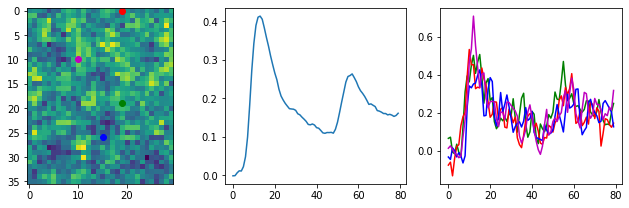

In [ ]:
SIexp = np.mean(datain, axis = 0)

fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=False)
axs[0].imshow(SIexp)
axs[1].plot(np.mean(datain,axis = (1,2)))
axs[0].plot(19, 19, 'o', color='g')
axs[2].plot(datain[:,19,19], color='g')
axs[0].plot(19, 0, 'o', color='r')
axs[2].plot(datain[:,19,0], color='r' )
axs[0].plot(15, 26, 'o', color='b')
axs[2].plot(datain[:,0,0], color='b')
axs[0].plot(10, 10, 'o', color='m')
axs[2].plot(datain[:,10,10], color='m')


fig.tight_layout()
plt.show()

In [ ]:
nE,ny,nx = datain.shape

data_cleaned = np.empty((nE,ny,nx))
datatemp = np.empty((1,1,nE))

for i in range(ny):
  for j in range(nx):
      datatemp[0,0,:] = datain[:,i,j]
      x_new = torch.from_numpy(datatemp).cuda()
      x_new=x_new.type(torch.cuda.FloatTensor)
      with torch.no_grad():
          prediction = model(x_new)
      data_cleaned[:,i,j] = prediction[0,0].cpu()


Now view results

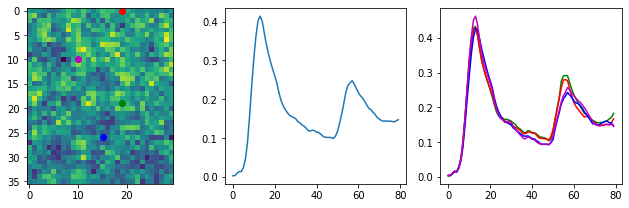

In [ ]:
SIexp = np.mean(data_cleaned, axis = 0)

fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=False)
axs[0].imshow(SIexp)
axs[1].plot(np.mean(data_cleaned,axis = (1,2)))
axs[0].plot(19, 19, 'o', color='g')
axs[2].plot(data_cleaned[:,19,19], color='g')
axs[0].plot(19, 0, 'o', color='r')
axs[2].plot(data_cleaned[:,19,0], color='r' )
axs[0].plot(15, 26, 'o', color='b')
axs[2].plot(data_cleaned[:,0,0], color='b')
axs[0].plot(10, 10, 'o', color='m')
axs[2].plot(data_cleaned[:,10,10], color='m')


fig.tight_layout()
plt.show()


Option to download final result for plotting etc.

In [ ]:
np.save('Fe_cleaned_fac.npy',data_cleaned)

from google.colab import files
files.download("/content/Fe_cleaned_fac.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>